,Draw,Date,Winning Number 1,Winning Number 2,Winning Number 3,Winning Number 4,Winning Number 5,Winning Number 6,Additional Number,From Last,Odd,Even,1-10,11-20,21-30,31-40,41-50,Year,Month,Day_of_Week
0,3766,2022-05-19,5,8,13,20,21,46,31,"21,46",3,3,2,2,1,0,1,2022,5,3
1,3765,2022-05-16,21,22,40,41,42,46,9,"41,46",2,4,0,0,2,1,3,2022,5,0
2,3764,2022-05-12,15,20,36,38,41,46,10,15,2,4,0,2,0,2,2,2022,5,3
3,3763,2022-05-09,5,12,15,21,30,39,6,39,4,2,1,2,2,1,0,2022,5,0
4,3762,2022-05-05,7,13,35,39,41,45,1,35,6,0,1,1,0,2,2,2022,5,3


/var/folders/26/1sqcgyf96cb0q8fj7pqq1c5m0000gn/T/ipykernel_1066/2710307167.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq_df['Number'], y=freq_df['Frequency'], palette='viridis')


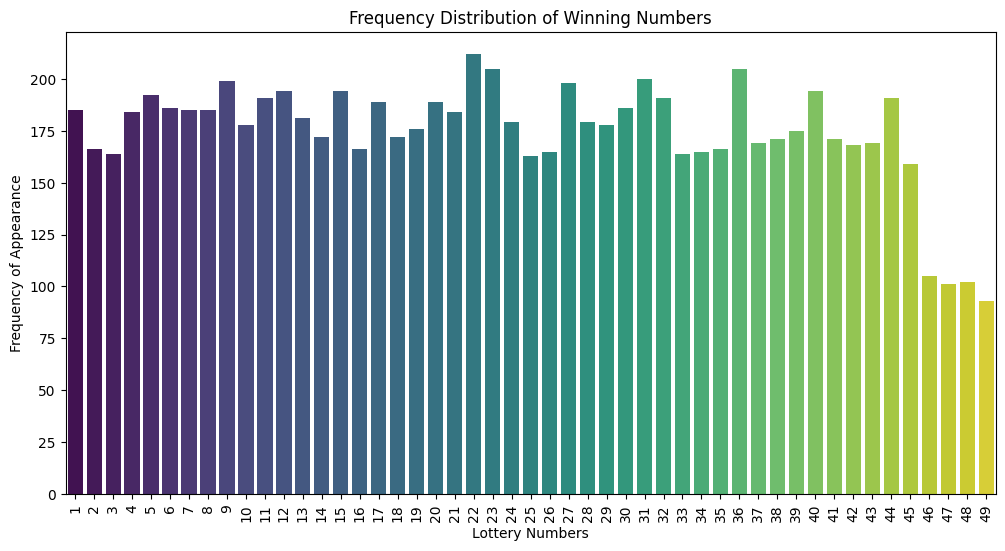

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr


Training models for Winning Number 1
Decision Tree Accuracy for Winning Number 1: 0.1193
              precision    recall  f1-score   support

           1       0.16      0.20      0.18        35
           2       0.13      0.16      0.14        25
           3       0.10      0.08      0.09        25
           4       0.13      0.12      0.13        32
           5       0.19      0.16      0.18        31
           6       0.06      0.06      0.06        18
           7       0.13      0.09      0.11        22
           8       0.05      0.05      0.05        19
           9       0.14      0.11      0.12        18
          10       0.10      0.17      0.12         6
          11       0.07      0.10      0.08        10
          12       0.25      0.17      0.20         6
          13       0.25      0.20      0.22         5
          14       0.20      0.17      0.18         6
          15       0.14      0.20      0.17         5
          16       0.00      0.00      0.00  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Random Forest Accuracy for Winning Number 2: 0.0491
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.09      0.08      0.09        12
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00        15
           8       0.10      0.06      0.07        18
           9       0.00      0.00      0.00        13
          10       0.11      0.08      0.09        24
          11       0.06      0.04      0.05        24
          12       0.07      0.15      0.10        13
          13       0.08      0.14      0.10        14
          14       0.00      0.00      0.00        16
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         4
          17       0.08      0.08      0.08        12
          18       0.00      

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.05      0.10      0.07        10
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.12      0.13      0.13        15
          13       0.04      0.10      0.05        10
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        15
          16       0.08      0.08      0.08        12
          17       0.06      0.08      0.07        12
          18       0.07      0.12      0.09         8
          19       0.00      0.00      0.00        14
          20       0.00    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          21       0.17      0.17      0.17         6
          22       0.00      0.00      0.00         2
          23       0.00      0.00      0.00         4
          24       0.00      0.00      0.00         5
          25       0.00      0.00      0.00         5
          26       0.00      0.00      0.00        10
          27       0.00      0.00      0.00         9
          28       0.00      0.00      0.00        11
          29       0.00      0.00      0.00         9
          30       0.00      0.00      0.00         8
          31       0.00      0.00      0.00        13
          32       0.00    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Random Forest Accuracy for Winning Number 6: 0.0632
              precision    recall  f1-score   support

          21       0.00      0.00      0.00         2
          26       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         2
          28       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         7
          30       0.00      0.00      0.00         4
          31       0.00      0.00      0.00         8
          32       0.00      0.00      0.00         6
          33       0.00      0.00      0.00         5
          34       0.00      0.00      0.00         4
          35       0.00      0.00      0.00         8
          36       0.00      0.00      0.00         5
          37       0.00      0.00      0.00        11
          38       0.00      0.00      0.00        15
          39       0.08      0.08      0.08        13
          40       0.00      0.00      0.00        13
          41       0.00      

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr


Training Decision Tree for Hot/Cold classification on Winning Number 1
Decision Tree Hot/Cold Accuracy for Winning Number 1: 0.9825
              precision    recall  f1-score   support

        Cold       1.00      0.98      0.99       257
         Hot       0.88      0.97      0.92        29

    accuracy                           0.98       286
   macro avg       0.94      0.97      0.95       286
weighted avg       0.98      0.98      0.98       286


Training Decision Tree for Hot/Cold classification on Winning Number 2
Decision Tree Hot/Cold Accuracy for Winning Number 2: 0.9930
              precision    recall  f1-score   support

        Cold       1.00      0.99      1.00       228
         Hot       0.97      1.00      0.98        58

    accuracy                           0.99       286
   macro avg       0.98      1.00      0.99       286
weighted avg       0.99      0.99      0.99       286


Training Decision Tree for Hot/Cold classification on Winning Number 3
Decision

/var/folders/26/1sqcgyf96cb0q8fj7pqq1c5m0000gn/T/ipykernel_1066/2710307167.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(next_draw_accuracies.keys()),


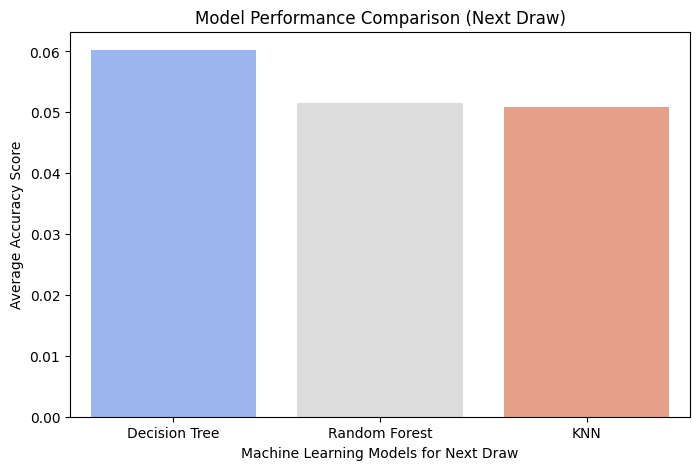

/var/folders/26/1sqcgyf96cb0q8fj7pqq1c5m0000gn/T/ipykernel_1066/2710307167.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(hot_cold_accuracies.keys()),


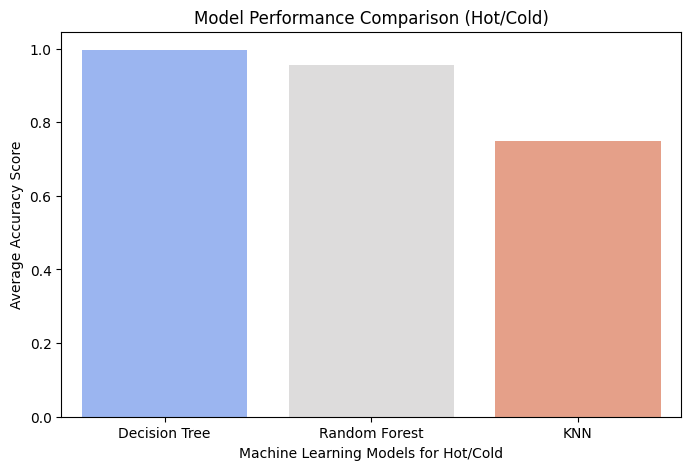

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load Dataset
df = pd.read_excel('./toto_cleaned_with_trends.xlsx')

# Display first few rows
display(df.head())

# Data Cleaning & Feature Engineering
def preprocess_data(df):
    winning_cols = [col for col in df.columns if 'Winning Number' in col]
    data = df[winning_cols].copy()
    data_matrix = data.to_numpy()
    
    # Frequency-based features
    all_numbers = np.arange(1, 50)
    frequency = {num: np.sum(data_matrix == num) for num in all_numbers}
    freq_df = pd.DataFrame(list(frequency.items()), columns=['Number', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    # Hot/Cold Labeling (Top 20% are Hot)
    threshold = int(len(freq_df) * 0.2)
    freq_df['Label'] = ['Hot' if i < threshold else 'Cold' for i in range(len(freq_df))]
    return data, freq_df

# Preprocess Data
data, freq_df = preprocess_data(df)

# Visualizing Frequency Distribution
plt.figure(figsize=(12,6))
sns.barplot(x=freq_df['Number'], y=freq_df['Frequency'], palette='viridis')
plt.xlabel('Lottery Numbers')
plt.ylabel('Frequency of Appearance')
plt.title('Frequency Distribution of Winning Numbers')
plt.xticks(rotation=90)
plt.show()

# Prepare the Data for Predicting Next Set of Numbers (Multi-Output Classification)
def prepare_next_draw_data(df):
    X = df.iloc[:-1, 2:8].values  # Use past draws as features
    y = df.iloc[1:, 2:8].values   # Use next draw as target
    return X, y

X, y = prepare_next_draw_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Separate Models for Each Winning Number
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Initialize a dictionary to store per-model, per-winning-number accuracy
next_draw_accuracies = {name: [] for name in models.keys()}

for i in range(y_train.shape[1]):  # Loop over each winning number position
    print(f'\nTraining models for Winning Number {i+1}')
    y_train_i = y_train[:, i]
    y_test_i = y_test[:, i]

    for name, model in models.items():
        model.fit(X_train, y_train_i)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test_i, y_pred)

        # Append accuracy for each model separately
        next_draw_accuracies[name].append(accuracy)

        print(f'{name} Accuracy for Winning Number {i+1}: {accuracy:.4f}')
        print(classification_report(y_test_i, y_pred))

# Compute average accuracy per model
for name in next_draw_accuracies:
    next_draw_accuracies[name] = np.mean(next_draw_accuracies[name])  # Get avg. accuracy per model

# Predicting Hot/Cold Numbers (Binary Classification)
def prepare_hot_cold_data(df, freq_df):
    # Generate Hot/Cold labels based on frequency
    winning_numbers = df.iloc[:, 2:8].values
    # Ensure that we have the correct shape of labels corresponding to the number of rows
    labels = np.array([['Hot' if num in freq_df[freq_df['Label'] == 'Hot']['Number'].values else 'Cold' for num in draw] for draw in winning_numbers])
    
    return winning_numbers, labels

X_hotcold, y_hotcold = prepare_hot_cold_data(df, freq_df)

# Ensure correct shape of y_hotcold for training
X_train, X_test, y_train, y_test = train_test_split(X_hotcold, y_hotcold, test_size=0.2, random_state=42)

# Train Hot/Cold Classifiers
hot_cold_models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

hot_cold_accuracies = {name: [] for name in hot_cold_models.keys()}

for name, model in hot_cold_models.items():
    for i in range(y_train.shape[1]):  # Loop over each winning number position
        print(f'\nTraining {name} for Hot/Cold classification on Winning Number {i+1}')
        y_train_i = y_train[:, i]  # Select the i-th column of labels
        y_test_i = y_test[:, i]

        model.fit(X_train, y_train_i)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test_i, y_pred)
        
        # Append accuracy per winning number
        hot_cold_accuracies[name].append(accuracy)

        print(f'{name} Hot/Cold Accuracy for Winning Number {i+1}: {accuracy:.4f}')
        print(classification_report(y_test_i, y_pred))

# Compute average accuracy per model
for name in hot_cold_accuracies:
    hot_cold_accuracies[name] = np.mean(hot_cold_accuracies[name])  # Get avg. accuracy per model
# Display Model Comparison for Next Draw
plt.figure(figsize=(8,5))
sns.barplot(x=list(next_draw_accuracies.keys()), 
            y=list(next_draw_accuracies.values()), 
            palette='coolwarm')
plt.xlabel('Machine Learning Models for Next Draw')
plt.ylabel('Average Accuracy Score')
plt.title('Model Performance Comparison (Next Draw)')
plt.show()

# Display Model Comparison for Hot/Cold Classification
plt.figure(figsize=(8,5))
sns.barplot(x=list(hot_cold_accuracies.keys()), 
            y=list(hot_cold_accuracies.values()), 
            palette='coolwarm')
plt.xlabel('Machine Learning Models for Hot/Cold')
plt.ylabel('Average Accuracy Score')
plt.title('Model Performance Comparison (Hot/Cold)')
plt.show()

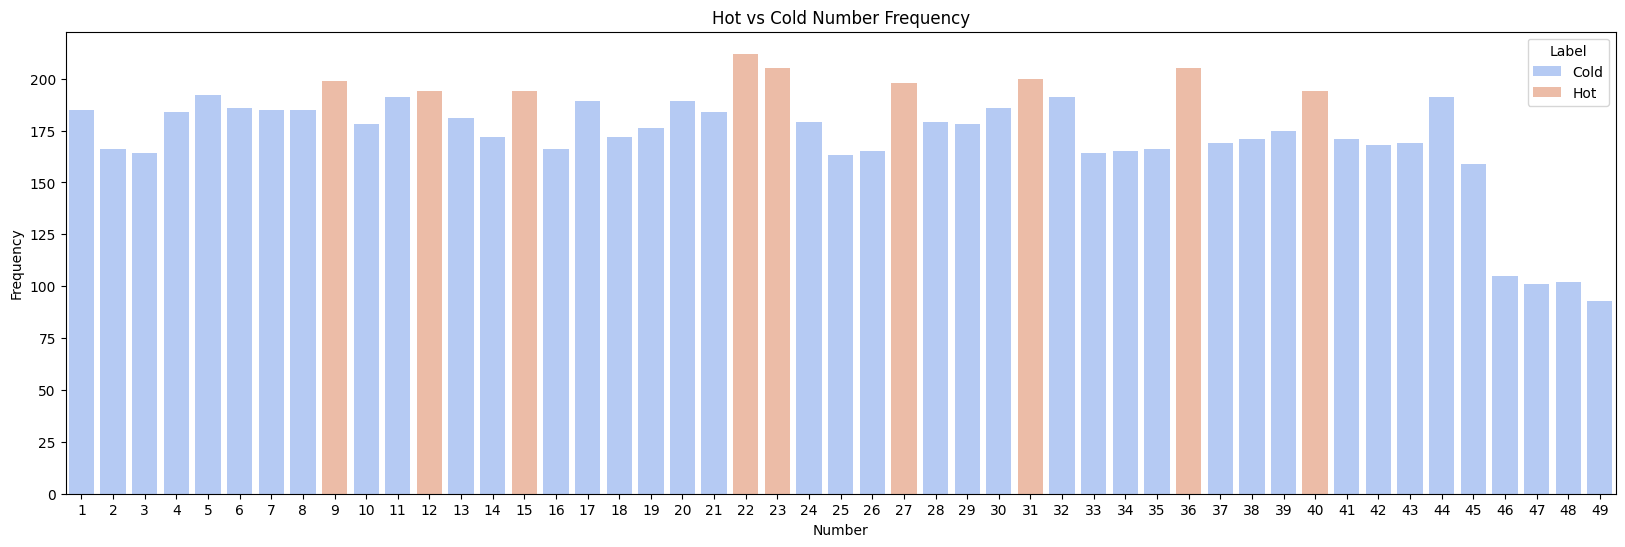


===== HotCold Classification =====
🔥 **Hot vs Cold**: Classifies numbers based on frequency. 'Hot' numbers appear frequently, while 'Cold' numbers appear less often.

Decision Tree Model:
Accuracy: 1.0
              precision    recall  f1-score   support

        Cold       1.00      1.00      1.00      1365
         Hot       1.00      1.00      1.00       351

    accuracy                           1.00      1716
   macro avg       1.00      1.00      1.00      1716
weighted avg       1.00      1.00      1.00      1716


Random Forest Model:
Accuracy: 1.0
              precision    recall  f1-score   support

        Cold       1.00      1.00      1.00      1365
         Hot       1.00      1.00      1.00       351

    accuracy                           1.00      1716
   macro avg       1.00      1.00      1.00      1716
weighted avg       1.00      1.00      1.00      1716


KNN Model:
Accuracy: 1.0
              precision    recall  f1-score   support

        Cold       1.00   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load Dataset
df = pd.read_excel('./toto_cleaned_with_trends.xlsx')

# Data Preprocessing
def preprocess_data(df):
    winning_cols = [col for col in df.columns if 'Winning Number' in col]
    data = df[winning_cols].copy()
    data_matrix = data.to_numpy()
    
    all_numbers = np.arange(1, 50)
    frequency = {num: np.sum(data_matrix == num) for num in all_numbers}
    freq_df = pd.DataFrame(list(frequency.items()), columns=['Number', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    threshold = int(len(freq_df) * 0.2)
    freq_df['Label'] = ['Hot' if i < threshold else 'Cold' for i in range(len(freq_df))]
    
    # Visualization of Hot and Cold Numbers
    plt.figure(figsize=(20, 6))
    sns.barplot(x='Number', y='Frequency', data=freq_df, hue='Label', palette="coolwarm")
    plt.title('Hot vs Cold Number Frequency')
    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.legend(title="Label")
    plt.show()
    
    return data, freq_df

data, freq_df = preprocess_data(df)

# Function to Prepare Data and Labels
def prepare_labels(df, label_type):
    winning_numbers = df.iloc[:, 2:8].values
    if label_type == 'HotCold':
        labels = np.array([['Hot' if num in freq_df[freq_df['Label'] == 'Hot']['Number'].values else 'Cold' for num in draw] for draw in winning_numbers])
    elif label_type == 'LowHigh':
        labels = np.array([['Low' if num <= 25 else 'High' for num in draw] for draw in winning_numbers])
    elif label_type == 'EvenOdd':
        labels = np.array([['Even' if num % 2 == 0 else 'Odd' for num in draw] for draw in winning_numbers])
    elif label_type == 'RepeatNew':
        prev_draw = df.iloc[:-1, 2:8].values  # Previous draw numbers
        labels = np.array([['Repeat' if num in prev_draw[i] else 'New' for i, num in enumerate(draw)] for draw in winning_numbers])
    return winning_numbers, labels

# Function to Train and Evaluate Models
def train_and_evaluate_models(label_type, consolidated_numbers):
    X, y = prepare_labels(df, label_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    # Display Classification Type Description
    classification_desc = {
        'HotCold': "🔥 **Hot vs Cold**: Classifies numbers based on frequency. 'Hot' numbers appear frequently, while 'Cold' numbers appear less often.",
        'LowHigh': "📊 **Low vs High**: Classifies numbers as 'Low' (1-25) or 'High' (26-49).",
        'EvenOdd': "🔢 **Even vs Odd**: Determines whether a number is even or odd.",
        'RepeatNew': "🔄 **Repeat vs New**: Checks if a number has appeared in the previous draw (Repeat) or is a new occurrence (New)."
    }
    
    print(f"\n===== {label_type} Classification =====")
    print(classification_desc[label_type])
    
    best_model = None
    best_accuracy = 0

    for name, model in models.items():
        # Reshaping the data to match model expectations
        model.fit(X_train.reshape(-1, 1), y_train.ravel())  # Ensuring y_train is a 1D array
        y_pred = model.predict(X_test.reshape(-1, 1))
        acc = accuracy_score(y_test.ravel(), y_pred.ravel())  # Flatten y_test and y_pred for accuracy

        print(f"\n{name} Model:")
        print("Accuracy:", acc)
        print(classification_report(y_test.ravel(), y_pred.ravel()))  # Flattening y_test and y_pred

        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model
    
    # Highlight Key Takeaways
    print(f"\n📌 **Key Takeaway:** The best-performing model is **{best_model.__class__.__name__}** with **{best_accuracy:.2%} accuracy**.")

    # Suggest TOTO Winning Numbers Based on Model Prediction
    suggested_numbers = np.random.choice(freq_df[freq_df['Label'] == 'Hot']['Number'].values, 3, replace=False).tolist() + \
                        np.random.choice(freq_df[freq_df['Label'] == 'Cold']['Number'].values, 3, replace=False).tolist()
    
    print(f"\n🔥 **Suggested TOTO Winning Numbers:** {suggested_numbers}")
    print("📌 **Tip:** This set includes both frequently drawn ('Hot') and less frequent ('Cold') numbers for balance.")
    
    # Append the suggested numbers to the consolidated list
    consolidated_numbers[label_type] = suggested_numbers

# Initialize dictionary to store consolidated numbers
consolidated_numbers = {}

# Train and evaluate each model with explanations
train_and_evaluate_models('HotCold', consolidated_numbers)
train_and_evaluate_models('LowHigh', consolidated_numbers)
train_and_evaluate_models('EvenOdd', consolidated_numbers)
train_and_evaluate_models('RepeatNew', consolidated_numbers)

# Consolidate all winning numbers
all_suggested_numbers = list(set([num for nums in consolidated_numbers.values() for num in nums]))

print(f"\n===== Consolidated TOTO Winning Numbers =====")
print(f"🔥 **Consolidated TOTO Winning Numbers:** {all_suggested_numbers}")
print("📌 **Tip:** This set is a combination of all suggestions from the different classifications.")
